# Quick start

Pre-define function `safy_yfinance_download` and `download_returns` since `yfinance` package is removed from `quantstats` for compatibility.

In [1]:
from typing import List, Optional, Union
import warnings

import pandas as pd
import yfinance as yf

def safe_yfinance_download(tickers: Union[str, List[str]],
                           proxy: Optional[str] = None,
                           **kwargs) -> pd.DataFrame:
    """
    Safe yfinance download that handles proxy configuration properly.

    This function provides a wrapper around yfinance.download that handles
    proxy configuration differences between yfinance versions. It ensures
    compatibility with both old and new yfinance proxy configuration methods.

    Parameters
    ----------
    tickers : str or list
        Ticker symbols to download data for. Can be a single ticker string
        or a list of ticker symbols
    proxy : str, optional
        Proxy configuration string (e.g., 'http://proxy.server:port')
        Handled automatically based on yfinance version
    **kwargs
        Additional arguments passed to yfinance.download such as:
        - start: Start date for data download
        - end: End date for data download
        - period: Period to download (e.g., '1y', '6mo')
        - interval: Data interval (e.g., '1d', '1h')

    Returns
    -------
    pd.DataFrame
        Downloaded financial data with columns like Open, High, Low, Close, Volume

    Examples
    --------
    >>> data = safe_yfinance_download('AAPL', start='2020-01-01', end='2021-01-01')
    >>> data = safe_yfinance_download(['AAPL', 'MSFT'], period='1y')
    """
    # Handle proxy configuration based on yfinance version
    if proxy is not None:
        # Check if the new configuration method exists in yfinance
        if hasattr(yf, "set_config"):
            # New method: use set_config for global proxy configuration
            # This approach is preferred in newer yfinance versions
            yf.set_config(proxy=proxy)
            # Remove proxy from kwargs to avoid duplicate parameter error
            kwargs.pop("proxy", None)
        else:
            # Old method: pass proxy directly to download function
            # This is for backward compatibility with older yfinance versions
            kwargs["proxy"] = proxy

    # Suppress yfinance warnings about deprecation and future changes
    # This keeps the output clean while maintaining functionality
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
        # Download the data using yfinance with all provided parameters
        result = yf.download(tickers, **kwargs)

        # Handle case where yfinance returns None (network issues, invalid ticker, etc.)
        if result is None:
            cols = pd.Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
            # Return empty DataFrame with standard yfinance columns
            return pd.DataFrame(columns=cols)

        return result


def yfinance_download_returns(ticker, period="max", proxy=None):
    """
    Download returns data for a given ticker using yfinance

    Parameters
    ----------
    ticker : str
        Stock ticker symbol
    period : str or pd.DatetimeIndex, default "max"
        Time period for data download
    proxy : str, optional
        Proxy server for download

    Returns
    -------
    pd.Series
        Daily returns data for the ticker
    """
    # Set up parameters for yfinance download
    params = {
        "tickers": ticker,
        "auto_adjust": True,
        "multi_level_index": False,
        "progress": False,
    }

    # Handle different period types
    if isinstance(period, pd.DatetimeIndex):
        params["start"] = period[0]
    else:
        params["period"] = period

    # Download data and calculate returns
    df = safe_yfinance_download(proxy=proxy, **params)["Close"].pct_change()  # type: ignore
    df = df.tz_localize(None)
    
    return df

In [2]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = yfinance_download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
# stock.sharpe()

np.float64(0.7688619785153967)

In [3]:
type(stock)

pandas.core.series.Series

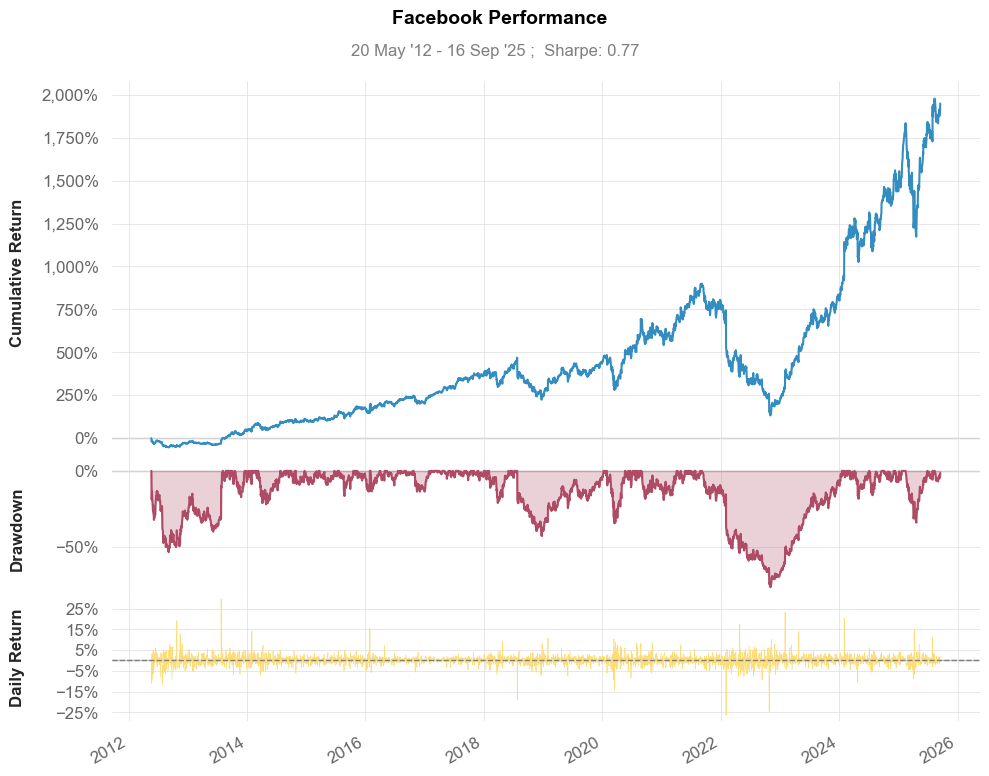

In [4]:
# Visualize stock performance
qs.plots.snapshot(stock, title="Facebook Performance", show=True)

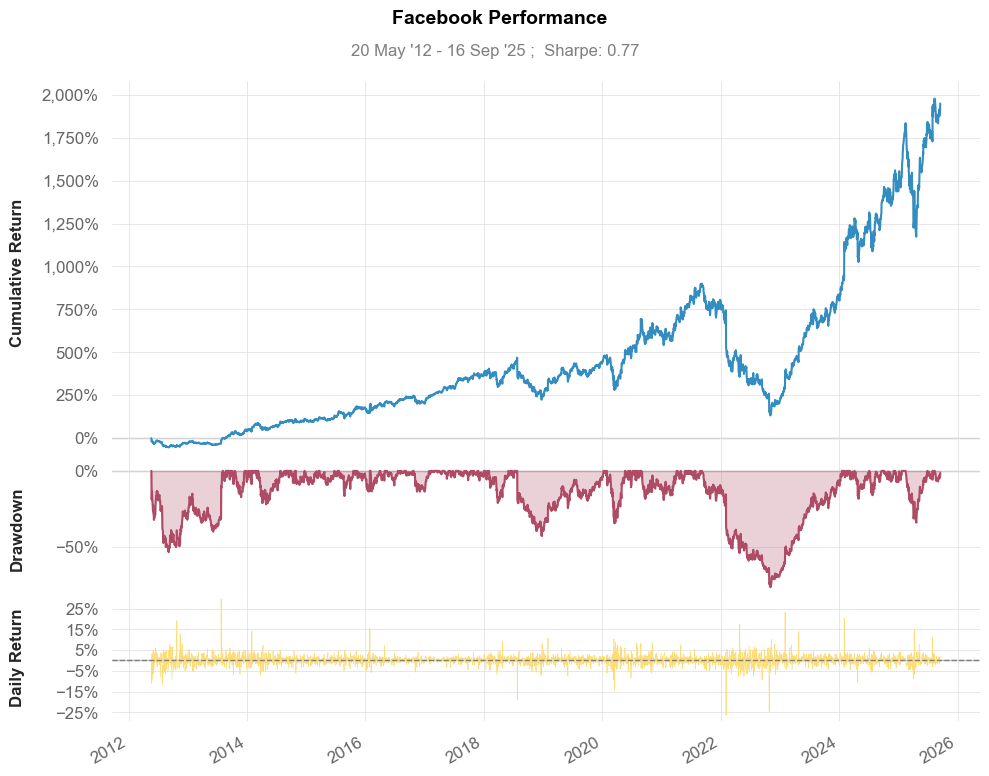

In [5]:
# Can also be called via:
stock.plot_snapshot(title='Facebook Performance', show=True)

# Creating a report

You can create 7 different report sheets:

1. `qs.reports.metrics(mode='basic|full", ...)` - shows basic/full metrics
2. `qs.reports.plots(mode='basic|full", ...)` - shows basic/full plots
3. `qs.reports.basic(...)` - shows basic metrics and plots
4. `qs.reports.full(...)` - shows full metrics and plots
5. `qs.reports.html(...)` - generates a complete report as html

Let's create an html report.

In [6]:
spy = yfinance_download_returns("SPY")

In [7]:
# Benchmark should be a pandas.Series
qs.reports.html(stock, benchmark=spy, download_filename="META-performance.html")

In [8]:
from IPython.display import HTML, display

with open("./examples/META-performance.html", "r", encoding="utf-8") as f:
    html_content = f.read()
# Display the HTML content
display(HTML(html_content))